In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import itertools
from wordcloud import WordCloud

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy import displacy

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_excel('/content/drive/MyDrive/dslab/final_combined_courses.xlsx')

# Display basic information about the dataset
print("Dataset overview:")
df.info()
df.head()

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   course_title          736 non-null    object
 1   Description           736 non-null    object
 2   original_description  736 non-null    object
 3   extracted_skills      713 non-null    object
 4   combined_description  736 non-null    object
dtypes: object(5)
memory usage: 28.9+ KB


,course_title,Description,original_description,extracted_skills,combined_description
0,Introduction to Data Science Tools,This course introduces graduate students to es...,this course introduces graduate students to es...,information theory,"introduction to data science tools, this cours..."
1,Research Methods and Scientific Ethics,This course aims to familiarise students with ...,this course aims to familiarise students with ...,"algorithms, big data, data science, decision t...","research methods and scientific ethics, this c..."
2,Cyber Security Basics,Operation System (OS) purposes are resource ma...,operation system os purposes are resource mana...,"microsoft access, authentications, encryption,...","cyber security basics, operation system os pur..."
3,Computer Networks and Security,This course will equip students with fundament...,this course will equip students with fundament...,"application security, cyber threat intelligenc...","computer networks and security, this course wi..."
4,Operating Systems and System Programming,The course covers principles of building secur...,the course covers principles of building secur...,"5g technology, access controls, android operat...","operating systems and system programming, the ..."


#Exploratory Data Analysis

In [11]:
# Check for the missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
course_title             0
Description              0
original_description     0
extracted_skills        23
combined_description     0
dtype: int64


In [34]:
# Check for duplicates
duplicate_titles = df['course_title'].duplicated().sum()
duplicate_descriptions = df['Description'].duplicated().sum()
print("Duplicate course titles:", duplicate_titles)
print("\nDuplicate course descriptions:", duplicate_descriptions)

Duplicate course titles: 65

Duplicate course descriptions: 1


No missing values in the course titles and descriptions.

But there are a quite a few duplicates in the course titles.

In [36]:
# Group by course title and check for different descriptions
duplicate_courses = df[df.duplicated(subset=['course_title'], keep=False)]

# Count unique descriptions per title
unique_descriptions_per_title = duplicate_courses.groupby('course_title')['Description'].nunique()

# Find titles with multiple unique descriptions
titles_with_different_descriptions = unique_descriptions_per_title[unique_descriptions_per_title > 1]

# Display the count and some examples
print(f"Number of course titles with different descriptions: {len(titles_with_different_descriptions)}")
print(titles_with_different_descriptions)

Number of course titles with different descriptions: 37
course_title
Access and Transport Networks                          2
Advanced Algorithms                                    2
Advanced Methods in Cryptography                       2
Advanced Topics in Information Technology Security     2
Applied Cryptography                                  12
Artificial Intelligence                                3
Computer Algebra for Cryptography                      2
Critical Infrastructure Protection                     2
Cryptanalysis                                          2
Cryptographic protocols                                2
Cryptography                                           4
Cryptography and Network Security                      2
Cyber Warfare                                          3
Cybercrime and Cybersecurity                           2
Databases and Security                                 2
Design of Digital Platforms                            2
Digital Forensics  

These courses have multiple descriptions.

In [44]:
# Inspect the lenght of the course titles
print("Course title lengths information:")
df['title_length'] = df['course_title'].apply(lambda x: len(str(x).split()))
print(df['title_length'].describe())

# Inspect the lenght of the descriptions
print("\nCourse description lengths information:")
df['desc_length'] = df['Description'].apply(lambda x: len(str(x).split()))
print(df['desc_length'].describe())

# Top 10 longest course descriptions
print("\nTop 10 longest course descriptions:")
print(df.nlargest(10, 'desc_length')[['course_title', 'desc_length']])

Course title lengths information:
count    736.000000
mean       3.680707
std        1.738702
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       11.000000
Name: title_length, dtype: float64

Course description lengths information:
count     736.000000
mean      207.577446
std       150.161598
min        13.000000
25%        99.750000
50%       171.000000
75%       270.250000
max      1057.000000
Name: desc_length, dtype: float64

Top 10 longest course descriptions:
                                       course_title  desc_length
125               Cryptography and Network Security         1057
209                        Security Infrastructures          898
140                  Software for Real-Time Control          851
373                             Distributed Systems          826
417            Television Technology and Multimedia          792
544            Network Control Systems and Security          754
538       Data Driven Models For Sys

**Insights on titles**
- Titles have an average of 3.68 words (min: 1, max: 11)
- 50% of the titles are 3 words or fewer

**Insights on descriptions**
- Average description length: 207 words
- Shortest description: 13 words
- Longest: 1057 words
- 50% of descriptions are 171 words or fewer

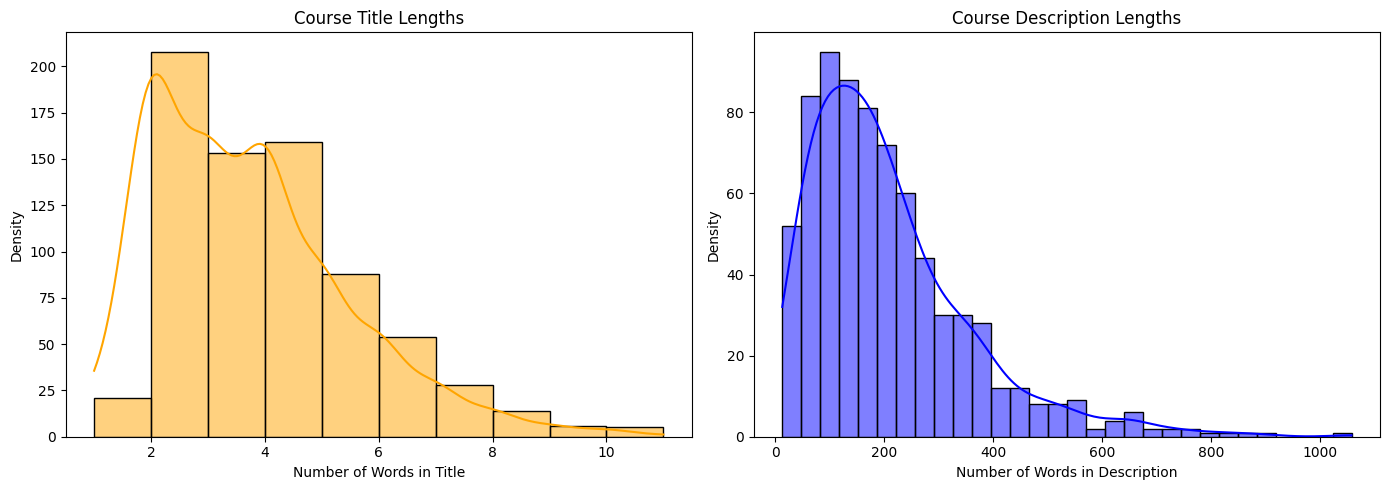

In [42]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KDE Plot for Course Title Lengths
sns.histplot(df['title_length'], bins=10, kde=True, color="orange", ax=axes[0])
axes[0].set_xlabel("Number of Words in Title")
axes[0].set_ylabel("Density")
axes[0].set_title("Course Title Lengths")

# KDE Plot for Course Description Lengths
sns.histplot(df['desc_length'], bins=30, kde=True, color="blue", ax=axes[1])
axes[1].set_xlabel("Number of Words in Description")
axes[1].set_ylabel("Density")
axes[1].set_title("Course Description Lengths")

# Adjust layout
plt.tight_layout()
plt.show()

**Course titles:**
- Most course titles contain around 3 to 5 words, as indicated by the peak
- Very short (1-2 words) or very long (8+ words) titles are less common

**Course descriptions:**
- Most course descriptions fall in the range of 50 to 300 words
- The distribution is right-skewed, meaning some descriptions are very long (500+ words)


Both distributions are right-skewed, meaning a few courses have significantly longer titles or descriptions than the majority

In [26]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=420b40a77d991ff45bd3539acaa7b383bbbc4569b6838b1dd3a46c0a43e41f82
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [38]:
# Checking if the descriptions contains other languages than english
# Because NER does not perform well on non-english texts
from langdetect import detect

df["language"] = df['Description'].dropna().apply(lambda x: detect(x))
print(df["language"].value_counts())

language
en    736
Name: count, dtype: int64


## Word frequency analysis

In [6]:
stop_words = set(stopwords.words('english'))

In [7]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

In [8]:
df['desc_tokens'] = df['Description'].apply(preprocess_text)
df['desc_tokens'].head()

,desc_tokens
0,"[course, introduces, graduate, students, essen..."
1,"[course, aims, familiarise, students, data, sc..."
2,"[operation, system, os, purposes, resource, ma..."
3,"[course, equip, students, fundamental, knowled..."
4,"[course, covers, principles, building, secure,..."


In [9]:
df['title_tokens'] = df['course_title'].apply(preprocess_text)
df['title_tokens'].head()

,title_tokens
0,"[introduction, data, science, tools]"
1,"[research, methods, scientific, ethics]"
2,"[cyber, security, basics]"
3,"[computer, networks, security]"
4,"[operating, systems, system, programming]"


In [13]:
# Get word frequency
def get_most_frequent_words(df, column_name, num_words):
    all_words = [word for tokens in df[column_name] for word in tokens]
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(num_words)

    print(f"Most Common Words in {column_name}:")
    for word, freq in common_words:
        print(f"{word}: {freq}")

    return common_words

In [15]:
# Get most words from titles
common_words_title = get_most_frequent_words(df, column_name='title_tokens', num_words=10)
print('\n')

# Get most words from descriptions
common_words_desc = get_most_frequent_words(df, column_name='desc_tokens', num_words=20)

Most Common Words in title_tokens:
security: 189
systems: 68
management: 54
information: 53
cybersecurity: 48
cryptography: 44
advanced: 41
data: 39
software: 36
computer: 34


Most Common Words in desc_tokens:
security: 1973
course: 1350
systems: 1243
students: 1044
data: 849
information: 790
knowledge: 778
able: 694
learning: 627
basic: 598
design: 590
analysis: 538
management: 524
network: 510
networks: 499
student: 490
methods: 474
system: 471
software: 464
techniques: 437


- With 189 occurrences, "security" is the most frequently used word in course titles, indicating a heavy emphasis on security-related subjects

- Frequently used terms that emphasize information security, system management, and cybersecurity are "systems" (68), "management" (54), "information" (53), and "cybersecurity" (48)

- Additionally, "Cryptography" (44) appears frequently, suggesting a subset of courses pertaining to secure communication

- The frequency of "Advanced" (41) suggests many courses are designed for intermediate or expert students

- Words such as "data" (39), "software" (36), and "computer" (34) suggest a more general emphasis on subjects pertaining to technology

- The word "security" appears 1,973 times that indicates that security is a key topic in all of the courses

- According to the terms "course" (1350) and "students" (1044), a lot of descriptions highlight the benefits that students will experience

- "Data" (849) and "Systems" (1243) further emphasize the technical and infrastructure-related focus of these courses

- The terms "knowledge" (778), "able" (694), and "learning" (627) show that skill-building and student capabilities are commonly mentioned in descriptions

- Words that imply a focus on networking topics include "network" (510) and "networks" (499)

- Many courses teach practical approaches to problem-solving, as evidenced by terms like "methods" (474), "system" (471), "software" (464), and "techniques" (437)


<ipython-input-86-c1cf66cb8f4f>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-86-c1cf66cb8f4f>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


Text(0.5, 1.0, 'Top 20 Most Frequent Words in Course Descriptions')

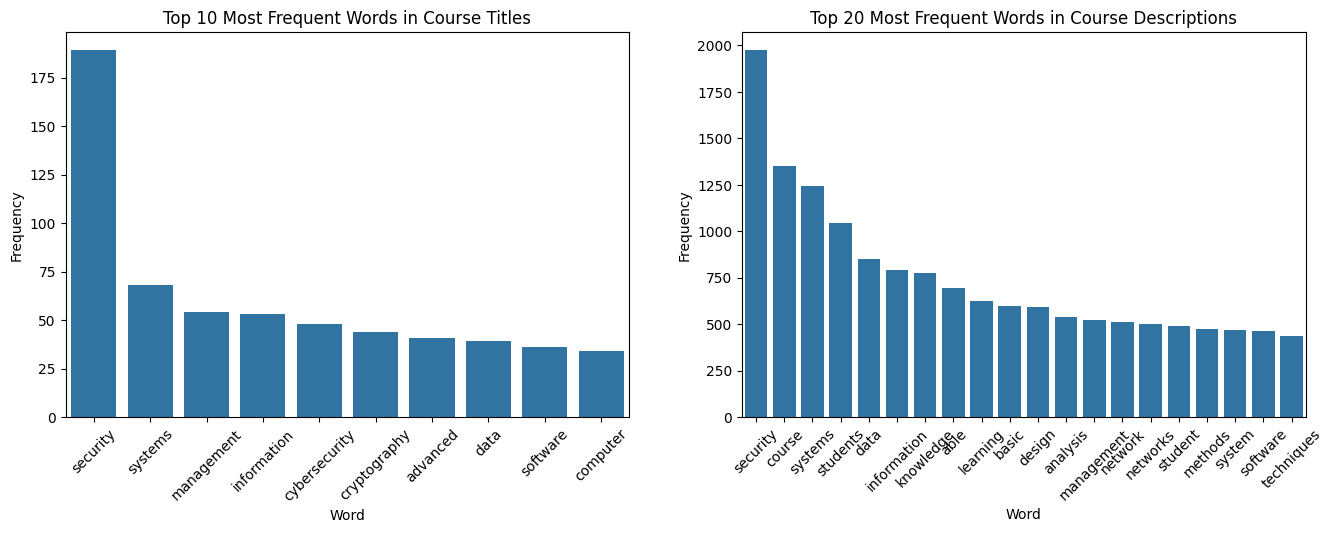

In [86]:
# Bar plot for the most frequent words
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Convert to DataFrame for plotting
word_freq_title = pd.DataFrame(common_words_title, columns=['word', 'count'])
word_freq_desc = pd.DataFrame(common_words_desc, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=word_freq_title, ax=axes[0])
axes[0].set_xlabel("Word")
axes[0].set_ylabel("Frequency")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title("Top 10 Most Frequent Words in Course Titles")

sns.barplot(x='word', y='count', data=word_freq_desc, ax=axes[1])
axes[1].set_xlabel("Word")
axes[1].set_ylabel("Frequency")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title("Top 20 Most Frequent Words in Course Descriptions")

(-0.5, 799.5, 399.5, -0.5)

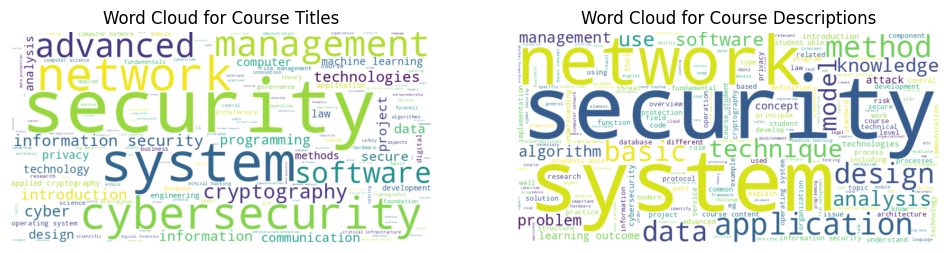

In [52]:
all_words_title = [word for tokens in df['title_tokens'] for word in tokens]
all_words_desc = [word for tokens in df['desc_tokens'] for word in tokens]

wordcloud_title = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_title))
wordcloud_desc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_desc))

# Word cloud for titles
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(wordcloud_title, interpolation='bilinear')
axes[0].set_title('Word Cloud for Course Titles')
axes[0].axis("off")

# Word cloud for descriptions
axes[1].imshow(wordcloud_desc, interpolation='bilinear')
axes[1].set_title('Word Cloud for Course Descriptions')
axes[1].axis("off")

In [29]:
# Analyze bigrams
bigrams = list(ngrams(all_words_desc, 2))
bigram_freq = Counter(bigrams).most_common(20)

# Convert to DataFrame
bigram_df = pd.DataFrame(bigram_freq, columns=['bigram', 'count'])

print("Most Common Bigrams:")
print(bigram_df)

Most Common Bigrams:
                     bigram  count
0   (information, security)    244
1      (learning, outcomes)    233
2          (students, able)    173
3           (student, able)    154
4        (course, students)    117
5       (machine, learning)    104
6         (cyber, security)    103
7      (operating, systems)     90
8         (course, student)     90
9    (information, systems)     83
10       (risk, management)     81
11        (access, control)     81
12            (end, course)     79
13        (basic, concepts)     77
14     (computer, security)     77
15      (network, security)     73
16   (security, management)     73
17       (data, protection)     73
18        (course, content)     72
19        (students, learn)     68


Even more profound insights into the themes and organization of the course material are provided by these most prevalent bigrams, which are word pairs that frequently occur together.

- **(information, security)** and **(cyber, security)** reinforce the idea that information security is the main topic
- **(computer, security)** and **(network, security)** suggest that different aspects of security are covered
- **(security, management)** and **(risk, management)** indicate that risk assessment and security governance are also major topics
- **(learning, outcomes)** and **(students, able)** suggest a strong emphasis on what students will achieve
- **(end, course)** likely refers to final objectives or outcomes stated at the conclusion of descriptions


With several bigrams focusing on cybersecurity, network security, risk management, and access control, security continues to be the most popular topic.
In addition to clearly defining what students will be able to do, course descriptions place a strong emphasis on student learning outcomes.
Data protection, operating systems, and machine learning are additional pertinent themes that demonstrate the variety of course subjects.

In [87]:
# Analyze trigrams
trigrams = list(ngrams(all_words_desc, 3))
trigram_freq = Counter(trigrams).most_common(20)

# Convert to DataFrame
trigram_df = pd.DataFrame(trigram_freq, columns=['trigram', 'count'])
print("Most Common Trigrams:")
print(trigram_df)

Most Common Trigrams:
                                   trigram  count
0          (basic, requirements, category)     50
1                 (course, students, able)     49
2                  (end, course, students)     46
3                  (course, student, able)     43
4      (information, security, management)     38
5         (new, littleknown, environments)     37
6      (littleknown, environments, within)     37
7           (intended, learning, outcomes)     36
8                (learning, outcomes, end)     35
9             (content, syllabus, outline)     34
10              (computer, security, data)     31
11          (security, data, intelligence)     31
12                 (outcomes, end, course)     31
13               (course, content, course)     29
14           (learning, outcomes, passing)     26
15             (outcomes, passing, course)     25
16         (environments, within, broader)     25
17    (within, broader, multidisciplinary)     25
18  (broader, multidisciplin

Trigrams we can provide an even richer understanding of course themes and structure.

Learning outcomes are clearly emphasized; descriptions usually list the goals that students will accomplish.
Data intelligence and security continue to be hot topics, supporting previous findings.

Other areas of emphasis include multidisciplinary learning and problem-solving.
In order to help students grasp expectations prior to enrollment, courses frequently outline prerequisites and syllabus specifics.


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf.fit_transform(df['Description'].dropna())
print(tfidf.get_feature_names_out())

['ability' 'able' 'access' 'advanced' 'algorithms' 'analysis'
 'application' 'applications' 'apply' 'aspects' 'attacks' 'based' 'basic'
 'business' 'communication' 'computer' 'concepts' 'content' 'control'
 'course' 'cryptographic' 'cryptography' 'cyber' 'cybersecurity' 'data'
 'design' 'develop' 'development' 'different' 'digital' 'engineering'
 'explain' 'field' 'general' 'identify' 'implementation' 'including'
 'information' 'introduction' 'issues' 'key' 'know' 'knowledge' 'learn'
 'learning' 'legal' 'level' 'main' 'management' 'mechanisms' 'methods'
 'model' 'models' 'module' 'network' 'networks' 'objectives' 'operating'
 'outcomes' 'practical' 'principles' 'privacy' 'problems' 'process'
 'processes' 'processing' 'programming' 'project' 'protection' 'protocols'
 'real' 'related' 'requirements' 'research' 'risk' 'secure' 'security'
 'services' 'skills' 'software' 'solutions' 'student' 'students' 'systems'
 'technical' 'techniques' 'technologies' 'testing' 'theory' 'threats'
 'time' 

In [88]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Get topic words
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([features[i] for i in topic.argsort()[-10:]])

Topic 1:
['theory', 'topics', 'course', 'security', 'algorithms', 'attacks', 'protocols', 'key', 'cryptographic', 'cryptography']
Topic 2:
['web', 'services', 'operating', 'secure', 'course', 'software', 'networks', 'network', 'systems', 'security']
Topic 3:
['threats', 'processes', 'course', 'cybersecurity', 'business', 'risk', 'information', 'management', 'cyber', 'security']
Topic 4:
['able', 'analysis', 'systems', 'basic', 'knowledge', 'methods', 'learning', 'data', 'course', 'students']
Topic 5:
['information', 'module', 'issues', 'course', 'cybersecurity', 'research', 'data', 'protection', 'privacy', 'legal']


##Name Entity Recognition

In [29]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [80]:
# Load spaCy NER model
nlp = spacy.load("en_core_web_sm")

# Process each description individually and store results
all_entities = []
for i, desc in enumerate(df["Description"].dropna()):
    doc = nlp(desc)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    all_entities.append(entities)
    if(i < 10):
      displacy.render(doc, style="ent", jupyter=True)

/usr/local/lib/python3.11/dist-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [74]:
# Print entities for the first 10 descriptions
for i, entities in enumerate(all_entities[:10]):
    print(f"\nEntities {i+1}:", entities)


Entities 1: []

Entities 2: [('Data Science and Big Data', 'ORG'), ('Visualization', 'PERSON'), ('Advanced Visualization', 'ORG'), ('Exploratory Data Analysis', 'ORG'), ('the Data Science Process', 'ORG'), ('EDA', 'ORG'), ('Extracting Meaning', 'PERSON'), ('Wrappers', 'ORG'), ('Decision Trees', 'PERSON'), ('Random Forests', 'PERSON'), ('Three', 'CARDINAL'), ('Data Science (Privacy, Security', 'ORG'), ('Ethics', 'ORG'), ('Inference', 'ORG'), ('EDA', 'ORG'), ('Linear Regression', 'ORG'), ('k-Nearest Neighbors', 'ORG'), ('Naive Bayes', 'PERSON'), ('SQL', 'ORG')]

Entities 3: [('Operation System', 'ORG'), ('File System', 'ORG'), ('Course Outcomes: Students', 'ORG'), ('Access', 'PRODUCT')]

Entities 4: [('Incident Response (Detection', 'ORG'), ('Mobile Security', 'ORG'), ('Social Engineering', 'ORG'), ('Legal', 'GPE'), ('Ethical', 'ORG')]

Entities 5: [('An Overview of Computer Security', 'ORG'), ('Linux/Unix Security Basics', 'ORG'), ('Buffer Overflow Vulnerability', 'ORG'), ('Attack', 'P

In [66]:
print('All entity types that spacy recognised from the course descriptions:')
unique_labels = set()
for doc_entities in all_entities:
    for ent_text, ent_label in doc_entities:
        unique_labels.add(ent_label)

# Print the entity labels
for label in unique_labels:
    print(label)

All entity types that spacy recognised from the course descriptions:
LOC
FAC
DATE
GPE
ORDINAL
QUANTITY
NORP
PERSON
WORK_OF_ART
TIME
PRODUCT
LAW
MONEY
PERCENT
EVENT
LANGUAGE
CARDINAL
ORG


In [83]:
locations = set()
facilites = set()

for entities in all_entities:
    for ent_text, ent_label in entities:
        if ent_label == 'LOC':
            locations.add(ent_text)
        elif ent_label == 'FAC':
            facilites.add(ent_text)

print('Locations from the course descriptions:')
for loc in locations:
    print(loc)
print('\nFacilities from the course descriptions:')
for fac in facilites:
    print(fac)

Locations from the course descriptions:
Europe II
Basel II/III
Birthday
Estimate
VoIP
STM-1
UHF RFID
Vulnerabilities
C. Basics
LaTeX. Bezier
Linux OS 9
IoT
Euclidean
MATLAB
Earth
Europe

Facilities from the course descriptions:
the Common Vulnerability Scoring System
SB100
Embedded Linux
STM-1
Cyberspace Battlefield
Learn
Merkle-Damgård
Unsupervised Learning K-Means Clustering Hierarchical Clustering
Deep Learning
Types of Ensembles - Algorithms: Bagging
Identify
True Random Number Generators
Puredata
Shannon
PV288
Students
